In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn import metrics
from sklearn.preprocessing import PowerTransformer
import missingno as msno

np.random.seed(123)

In [2]:
def show_full_data(data, row_size=None, column_size=None, col_width=-1):
    """
    Shows all rows and columns instead of showing only some part 
    and hiding other parts for large data.
    """
    with pd.option_context('display.max_rows', row_size, 
                           'display.max_columns', column_size, 
                           'display.max_colwidth', col_width):
        display(data)

In [3]:
df = pd.read_csv('combined_samples/combined_data_all_30min.csv')
# Eliminate first unnecessary column.
df = df.iloc[:, 1:]
show_full_data(df.head())

,timestamp,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked,sms,call_log,call_duration,deadlines,running_apps,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,STRESSED,hour_of_day
0,2013-03-27 04:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.333333,18.384776,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1799,0,0,0,1288,1,370,140.0,NaN,4
1,2013-03-27 04:30:00,213.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.000000,NaN,1.0,0.0,1.0,0.0,0.0,1515.0,1408.0,1.0,0.0,0.0,0.0,15.0,1800,0,0,0,1094,103,603,0.0,NaN,4
2,2013-03-27 05:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.000000,NaN,1.0,0.0,1.0,0.0,0.0,1800.0,1800.0,0.0,0.0,0.0,0.0,30.0,1800,0,0,0,1798,0,2,0.0,NaN,5
3,2013-03-27 05:30:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-62.000000,NaN,1.0,0.0,1.0,0.0,0.0,1800.0,1800.0,1.0,0.0,0.0,0.0,15.0,1800,0,0,0,1608,183,9,0.0,NaN,5
4,2013-03-27 06:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-61.750000,20.859650,2.0,1.0,1.0,1.0,534.0,1324.0,1043.0,0.0,0.0,0.0,0.0,36.0,1783,0,0,17,1797,1,2,0.0,NaN,6


In [4]:
# Total number of instances
print(df[df.STRESSED.notnull()].shape[0])

2335


In [5]:
##### DELETE
df = df.drop(columns=['call_duration'])

In [6]:
sorted(df.columns)

['STRESSED',
 'activity_inference_0',
 'activity_inference_1',
 'activity_inference_2',
 'activity_inference_3',
 'audio_inference_0',
 'audio_inference_1',
 'audio_inference_2',
 'audio_inference_3',
 'bt_level_avg',
 'bt_level_std',
 'bt_total_devices_around',
 'bt_total_far',
 'bt_total_farther',
 'bt_total_near',
 'bt_total_nearer',
 'call_log',
 'conversation',
 'deadlines',
 'hour_of_day',
 'phone_charging',
 'phone_in_dark',
 'phone_locked',
 'running_apps',
 'sms',
 'timestamp',
 'wifi_level_avg',
 'wifi_level_std',
 'wifi_total_devices_around',
 'wifi_total_far',
 'wifi_total_near',
 'wifi_total_nearer']

# Create Dataframe with Same Length Instances

In [7]:
sequence_length = 24

In [8]:
def create_same_length_instances(df, length=72, label='STRESSED'):
    df = df.drop(columns=['timestamp'])
    full_data = pd.DataFrame()
    indexes = list(df[df[label].notnull()].index) # Choose label indexes
    start = 0
    for i in indexes:
        if i - start >= length:
            # If the length of instance is higher than treshold length,
            # It chooses last timestamps (according to given length)
            instance = df.iloc[i-length+1:i+1, :]
            full_data = full_data.append(instance, ignore_index=True, sort=False)
        else:
            # If the length of instance is lower than treshold length,
            # It chooses all timestamps and add zeros to head timestamps until reach given length.
            index_diff = i - start
            instance = df.iloc[i-index_diff+1:i+1, :]
            back_fill = np.empty((length-index_diff, df.shape[1]))
            back_fill.fill(np.nan)
            back_fill = pd.DataFrame(back_fill, columns=df.columns)
            instance = back_fill.append(instance, ignore_index=True, sort=False)
            full_data = full_data.append(instance, ignore_index=True, sort=False)
        start = i
    return full_data

In [9]:
df_same = create_same_length_instances(df, length=sequence_length)

In [10]:
print('Total sample size:', df_same[df_same.STRESSED.notnull()].shape[0], '\n')
print('Each class size:\n' + str(df_same.STRESSED.value_counts()))

Total sample size: 2335 

Each class size:
1.0    1605
0.0     730
Name: STRESSED, dtype: int64


In [11]:
show_full_data(df_same[df_same.STRESSED.notnull()].head())

,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked,sms,call_log,deadlines,running_apps,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,STRESSED,hour_of_day
23,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-61.000000,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.0,1800.0,0.0,0.0,0.0,1783.0,8.0,9.0,0.0,1.0,2.0
47,245.0,-87.5,5.258913,7.0,3.0,3.0,1.0,0.0,-83.500000,8.811647,8.0,5.0,3.0,0.0,1600.0,0.0,1540.0,1.0,0.0,0.0,31.0,1397.0,4.0,216.0,183.0,1206.0,318.0,276.0,0.0,1.0,19.0
71,1765.0,-80.0,NaN,1.0,0.0,0.0,1.0,0.0,-86.000000,10.330778,10.0,7.0,3.0,0.0,1800.0,0.0,1800.0,0.0,0.0,0.0,16.0,1800.0,0.0,0.0,0.0,328.0,1328.0,144.0,0.0,1.0,19.0
95,1340.0,-85.0,8.598173,8.0,4.0,2.0,2.0,0.0,-82.333333,11.916406,18.0,14.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1334.0,272.0,194.0,0.0,119.0,1133.0,548.0,0.0,0.0,21.0
119,1107.0,-88.0,8.467048,11.0,5.0,5.0,1.0,0.0,-80.666667,10.966582,18.0,12.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1547.0,228.0,25.0,0.0,303.0,1032.0,465.0,0.0,0.0,22.0


# Normalize Data

In [12]:
df_same_labels = df_same.STRESSED.copy()
df_same = df_same.drop(columns='STRESSED')
df_columns = df_same.columns
pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt.fit(df_same)
df_norm = pt.transform(df_same)
df_norm = pd.DataFrame(df_norm, columns=df_columns)
df_norm['STRESSED'] = df_same_labels

In [13]:
# def normalize(df, label_col='STRESSED'):
#     features = df_same.drop(columns=label_col)
#     features_norm = (features - features.mean(axis=0)) / (features.max(axis=0) - features.min(axis=0))
#     df.loc[:, df.columns != label_col] = features_norm
#     return df

In [14]:
# df_norm = normalize(df_same)
show_full_data(df_norm.head())

,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked,sms,call_log,deadlines,running_apps,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,hour_of_day,STRESSED
0,1.176726,-0.129004,-0.056179,1.238905,1.086896,0.797438,1.242990,1.617221,-1.629940,-1.060900,2.010535,2.418037,0.563125,-1.178020,-0.870228,-0.553342,-1.077649,-0.950172,1.600311,-0.553583,0.466801,-2.165540,1.644484,-0.387288,-0.634389,-1.244563,1.352970,0.643235,-0.011611,0.316035,NaN
1,1.080720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.205752,0.692240,2.142012,1.662174,2.561406,1.755748,-0.870228,-0.553342,-1.077649,1.036573,1.600311,-0.553583,-0.038702,-2.385363,1.654075,-0.387288,-0.634389,-1.099661,1.048535,1.073792,-0.011611,0.316035,NaN
2,-0.968227,-0.134524,-0.395288,1.424520,1.578052,1.413145,0.968151,-0.587973,-0.575743,0.014510,0.579727,0.758918,-0.097802,0.294684,-0.870228,-0.553342,-1.077649,-0.950172,-0.623578,-0.553583,0.674698,0.604207,-0.672658,-0.387288,-0.634389,0.856342,-0.171642,-0.263729,-0.011611,0.452282,NaN
3,-0.968227,-0.134524,-0.146424,1.470962,1.458150,1.599101,1.242990,-0.587973,-0.124546,0.287872,0.700462,0.897418,-0.531822,0.294684,-0.870228,-0.553342,-1.077649,1.036573,-0.623578,-0.553583,-0.139838,0.297560,1.318262,-0.387288,1.557480,0.615225,-0.794571,0.549418,-0.011611,0.452282,NaN
4,-0.968227,-0.131758,-0.186678,1.238905,1.578052,0.797438,0.448726,-0.587973,-0.701798,-0.185235,0.700462,0.897418,-0.097802,-1.178020,-0.870228,-0.553342,-1.077649,-0.950172,-0.623578,-0.553583,0.674698,0.532345,1.067393,-0.387288,-0.634389,0.616489,-1.077199,0.552808,-0.011611,0.588076,NaN


In [15]:
print('Total sample size:', df_norm[df_norm.STRESSED.notnull()].shape[0], '\n')
print('Each class size:\n' + str(df_norm.STRESSED.value_counts()))

Total sample size: 2335 

Each class size:
1.0    1605
0.0     730
Name: STRESSED, dtype: int64


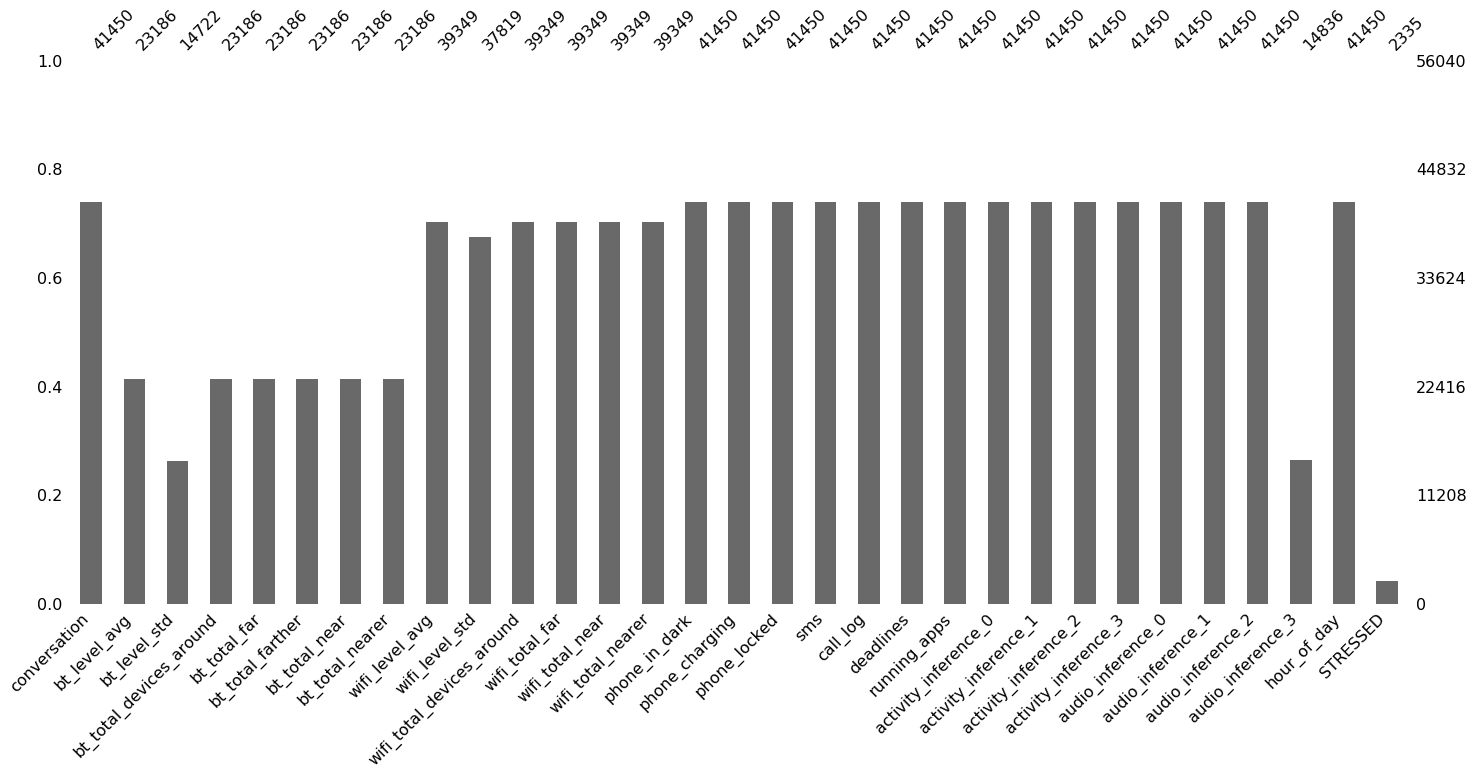

In [16]:
msno.bar(df_norm)

# Filling Missing Values

In [17]:
def fill_nulls(df, label_col='STRESSED', method=0):
    if method == 0:
        df.loc[:, df.columns != label_col] = df.loc[:, df.columns != label_col].fillna(0)
    elif method == 'mean':
        df.loc[:, df.columns != label_col] = df.loc[:, df.columns != label_col].fillna(df.loc[:, df.columns != label_col].mean())
    return df

In [18]:
df_filled = fill_nulls(df_norm, label_col='STRESSED', method=0)
show_full_data(df_filled.head())

,conversation,bt_level_avg,bt_level_std,bt_total_devices_around,bt_total_far,bt_total_farther,bt_total_near,bt_total_nearer,wifi_level_avg,wifi_level_std,wifi_total_devices_around,wifi_total_far,wifi_total_near,wifi_total_nearer,phone_in_dark,phone_charging,phone_locked,sms,call_log,deadlines,running_apps,activity_inference_0,activity_inference_1,activity_inference_2,activity_inference_3,audio_inference_0,audio_inference_1,audio_inference_2,audio_inference_3,hour_of_day,STRESSED
0,1.176726,-0.129004,-0.056179,1.238905,1.086896,0.797438,1.242990,1.617221,-1.629940,-1.060900,2.010535,2.418037,0.563125,-1.178020,-0.870228,-0.553342,-1.077649,-0.950172,1.600311,-0.553583,0.466801,-2.165540,1.644484,-0.387288,-0.634389,-1.244563,1.352970,0.643235,-0.011611,0.316035,NaN
1,1.080720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.205752,0.692240,2.142012,1.662174,2.561406,1.755748,-0.870228,-0.553342,-1.077649,1.036573,1.600311,-0.553583,-0.038702,-2.385363,1.654075,-0.387288,-0.634389,-1.099661,1.048535,1.073792,-0.011611,0.316035,NaN
2,-0.968227,-0.134524,-0.395288,1.424520,1.578052,1.413145,0.968151,-0.587973,-0.575743,0.014510,0.579727,0.758918,-0.097802,0.294684,-0.870228,-0.553342,-1.077649,-0.950172,-0.623578,-0.553583,0.674698,0.604207,-0.672658,-0.387288,-0.634389,0.856342,-0.171642,-0.263729,-0.011611,0.452282,NaN
3,-0.968227,-0.134524,-0.146424,1.470962,1.458150,1.599101,1.242990,-0.587973,-0.124546,0.287872,0.700462,0.897418,-0.531822,0.294684,-0.870228,-0.553342,-1.077649,1.036573,-0.623578,-0.553583,-0.139838,0.297560,1.318262,-0.387288,1.557480,0.615225,-0.794571,0.549418,-0.011611,0.452282,NaN
4,-0.968227,-0.131758,-0.186678,1.238905,1.578052,0.797438,0.448726,-0.587973,-0.701798,-0.185235,0.700462,0.897418,-0.097802,-1.178020,-0.870228,-0.553342,-1.077649,-0.950172,-0.623578,-0.553583,0.674698,0.532345,1.067393,-0.387288,-0.634389,0.616489,-1.077199,0.552808,-0.011611,0.588076,NaN


In [19]:
df_filled[df_filled['STRESSED'].notnull()].index

Int64Index([   23,    47,    71,    95,   119,   143,   167,   191,   215,
              239,
            ...
            55823, 55847, 55871, 55895, 55919, 55943, 55967, 55991, 56015,
            56039],
           dtype='int64', length=2335)

# Create X and y

## X

In [20]:
def create_instances(df, length=72, label='STRESSED'):
    # Converts dataframe to tensor instances to feed lstm network.
    total_instances = df[df[label].notnull()].shape[0]
    total_features = df[df[label].notnull()].shape[1] - 1
    indexes = list(df[df[label].notnull()].index)
    data = df.drop(columns=[label])
    all_data = np.empty(shape=(total_instances, length, total_features))
    for instance_no, label_index in enumerate(indexes):
        start = label_index - length + 1
        all_data[instance_no] = data.iloc[start:label_index+1, :].values
    return all_data

In [21]:
X = create_instances(df_filled, length=sequence_length)

In [22]:
print('Total number of instances:', X.shape[0])
print("One sample's sequence length:", X.shape[1])
print("Feature size:", X.shape[2])

Total number of instances: 2335
One sample's sequence length: 24
Feature size: 30


## y

In [23]:
y = df_filled.loc[df_filled['STRESSED'].notnull(), 'STRESSED'].values.reshape(X.shape[0],1)

In [24]:
y.shape

(2335, 1)

# Create Randomly Chosen Train and Test Data with Specific Size

In [25]:
# all_one_indexes = np.where(y == 1)[0]
# all_one_indexes.shape

In [26]:
# all_zero_indexes = np.where(y == 0)[0]
# all_zero_indexes.shape

In [27]:
# ones = np.random.choice(all_one_indexes, 500, replace=False)
# print(ones.shape)
# print(np.unique(ones).shape)

In [28]:
# zeros = np.random.choice(all_zero_indexes, 500, replace=False)
# print(zeros.shape)
# print(np.unique(zeros).shape)

In [29]:
# train_indexes = np.concatenate((ones, zeros))
# print(train_indexes.shape)
# print(np.unique(train_indexes).shape)

In [30]:
# train_indexes[:50]

In [31]:
# np.random.shuffle(train_indexes)

In [32]:
# train_indexes[:50]

In [33]:
# new_x = X[train_indexes, :, :]
# new_y = y[train_indexes, :]

In [34]:
# print(new_x.shape)
# print(new_y.shape)

In [35]:
# print(np.where(new_y == 1)[0].shape)
# print(np.where(new_y == 0)[0].shape)

In [36]:
# test_indexes = np.array([i for i in range(len(y)) if i not in train_indexes])
# print(test_indexes.shape)

In [37]:
# np.unique(list(set(train_indexes) - set(test_indexes))).shape

In [38]:
# not_used_ones = np.array(list(set(all_one_indexes) - set(ones)))
# print(not_used_ones.shape)
# print(np.unique(not_used_ones).shape)

In [39]:
# np.unique(list(set(not_used_ones) - set(train_indexes))).shape

In [40]:
# not_used_zeros = np.array(list(set(all_zero_indexes) - set(zeros)))
# print(not_used_zeros.shape)
# print(np.unique(not_used_zeros).shape)

In [41]:
# test_sample_size = min(len(not_used_ones), len(not_used_zeros))
# print(test_sample_size)

In [42]:
# test_ones = np.random.choice(not_used_ones, test_sample_size, replace=False)
# print(test_ones.shape)
# print(np.unique(test_ones).shape)

In [43]:
# test_zeros = np.random.choice(not_used_zeros, test_sample_size, replace=False)
# print(test_zeros.shape)
# print(np.unique(test_zeros).shape)

In [44]:
# test_indexes = np.concatenate((test_ones, test_zeros))

In [45]:
# np.random.shuffle(test_indexes)

In [46]:
# test_x = X[test_indexes, :, :]
# test_y = y[test_indexes, :]

In [47]:
# print(test_x.shape)
# print(test_y.shape)

In [48]:
# print(np.where(test_y == 1)[0].shape)
# print(np.where(test_y == 0)[0].shape)

In [49]:
# np.unique(list(set(train_indexes) - set(test_indexes))).shape

In [50]:
# np.unique(list(set(test_indexes) - set(train_indexes))).shape

In [51]:
def create_random_sets(x, y, train_size=1000, seed=1, balanced_test=False):
    # Randomly chooses created instances and created balanced train test set.
    # If balanced_test==True, it creates balanced test set. 
    # (If False, takes all remaning data as test.)
    random.seed(seed)
    one_class_size = int(train_size / 2)
    all_one_indexes = np.where(y == 1)[0]
    all_zero_indexes = np.where(y == 0)[0]
    ones = np.random.choice(all_one_indexes, one_class_size, replace=False)
    zeros = np.random.choice(all_zero_indexes, one_class_size, replace=False)
    train_indexes = np.concatenate((ones, zeros))
    np.random.shuffle(train_indexes)
    new_x = x[train_indexes, :, :]
    new_y = y[train_indexes, :]
    if balanced_test == False:
        test_indexes = np.array([i for i in range(len(y)) if i not in train_indexes])
        np.random.shuffle(test_indexes)
        test_x = x[test_indexes, :, :]
        test_y = y[test_indexes, :]
    else:
        not_used_ones = np.array(list(set(all_one_indexes) - set(ones)))
        not_used_zeros = np.array(list(set(all_zero_indexes) - set(zeros)))
        test_sample_size = min(len(not_used_ones), len(not_used_zeros))
        test_ones = np.random.choice(not_used_ones, test_sample_size, replace=False)
        test_zeros = np.random.choice(not_used_zeros, test_sample_size, replace=False)
        test_indexes = np.concatenate((test_ones, test_zeros))
        np.random.shuffle(test_indexes)
        test_x = x[test_indexes, :, :]
        test_y = y[test_indexes, :]
    return new_x, new_y, test_x, test_y, train_indexes, test_indexes

In [52]:
X_train, y_train, X_test, y_test, train_indexes, test_indexes = create_random_sets(X, y, train_size=1000, seed=123, balanced_test=True)

In [53]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1000, 24, 30)
y_train shape: (1000, 1)
X_test shape: (460, 24, 30)
y_test shape: (460, 1)


In [54]:
np.unique(test_indexes).shape

(460,)

In [55]:
# np.sort(test_indexes)

In [56]:
# np.sort(train_indexes)

In [57]:
# np.unique(train_indexes).shape

In [58]:
# len(list(set(train_indexes) - set(test_indexes)))

# Model 

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import GRU
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
import keras

Using TensorFlow backend.


In [60]:
max_features = 30

In [199]:
model = Sequential()
# model.add(Embedding(25, 10, input_length=sequence_length)) # Does not work.
# model.add(LSTM(64, activation='tanh', dropout=0.2, return_sequences=True, input_shape=(sequence_length, 30))) # returns a sequence of vectors of dimension 32
# model.add(LSTM(128, activation='tanh', return_sequences=True, dropout=0.5))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(32, activation='tanh', return_sequences=True))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(128, activation='tanh', return_sequences=True, dropout=0.5))  # returns a sequence of vectors of dimension 32
# model.add(Dense(32, activation='tanh'))


model.add(LSTM(64, activation='tanh', dropout=0.2))  # return a single vector of dimension 32
# model.add(GRU(64, activation='tanh', dropout=0.2))


model.add(Dense(64, activation='tanh'))
# model.add(Dense(64, activation='tanh'))
# model.add(Dense(32, activation='tanh'))
# model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [200]:
optim = Adam(lr=0.0003, 
             beta_1=0.9, 
             beta_2=0.999, 
             epsilon=None, 
             decay=0.0, 
             amsgrad=False)

# optim = Adagrad(lr=0.01, 
#                 epsilon=None, 
#                 decay=0.0)

# optim = SGD(lr=0.001, 
#             decay=1e-6, 
#             momentum=0.9, 
#             nesterov=True,
#             clipnorm=1.0)

In [201]:
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

In [202]:
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  min_delta=0.00001, 
                                  patience=100, 
                                  verbose=0, 
                                  mode='auto', 
                                  baseline=None, 
                                  restore_best_weights=True),
    
    keras.callbacks.ModelCheckpoint('model_weights/weights.{epoch:02d}-{val_acc:.2f}.hdf5',
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1),
    
    keras.callbacks.TensorBoard(log_dir='model_weights/tensorboard/', 
                                histogram_freq=0, 
                                batch_size=32, 
                                write_graph=True, 
                                write_grads=False, 
                                write_images=True, 
                                embeddings_freq=0, 
                                embeddings_layer_names=None, 
                                embeddings_metadata=None, 
                                embeddings_data=None, 
                                update_freq='epoch'), 
    
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                       factor=0.2, 
#                                       patience=10, 
#                                       min_lr=0.0001), 
    
    keras.callbacks.CSVLogger('model_weights/csv_logger/train_log.csv', separator=',', append=False)
]

In [203]:
model_history = model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=500, validation_split=0.2, shuffle=False, callbacks=my_callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 2s 2ms/step - loss: 0.6924 - acc: 0.5175 - val_loss: 0.6875 - val_acc: 0.5250
Epoch 2/500
800/800 [==============================] - 0s 119us/step - loss: 0.6951 - acc: 0.5150 - val_loss: 0.6868 - val_acc: 0.5300
Epoch 3/500
800/800 [==============================] - 0s 120us/step - loss: 0.6875 - acc: 0.5450 - val_loss: 0.6862 - val_acc: 0.5400
Epoch 4/500
800/800 [==============================] - 0s 125us/step - loss: 0.6833 - acc: 0.5550 - val_loss: 0.6856 - val_acc: 0.5250
Epoch 5/500
800/800 [==============================] - 0s 124us/step - loss: 0.6873 - acc: 0.5337 - val_loss: 0.6850 - val_acc: 0.5250
Epoch 6/500
800/800 [==============================] - 0s 112us/step - loss: 0.6844 - acc: 0.5650 - val_loss: 0.6844 - val_acc: 0.5350
Epoch 7/500
800/800 [==============================] - 0s 127us/step - loss: 0.6856 - acc: 0.5350 - val_loss: 0.6839 - val_acc: 0.5350
Epoch 8/500

In [204]:
score = model.evaluate(X_test, y_test)

460/460 [==============================] - 0s 613us/step


In [205]:
print(score)

[0.6641575637071029, 0.6282608700835186]


In [206]:
score_train = model.evaluate(X_train, y_train)

1000/1000 [==============================] - 1s 772us/step


In [207]:
print(score_train)

[0.5618088927268982, 0.713]


In [208]:
model.save('LSTM_Model.h5')

In [71]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

In [72]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [209]:
history = model_history

In [210]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

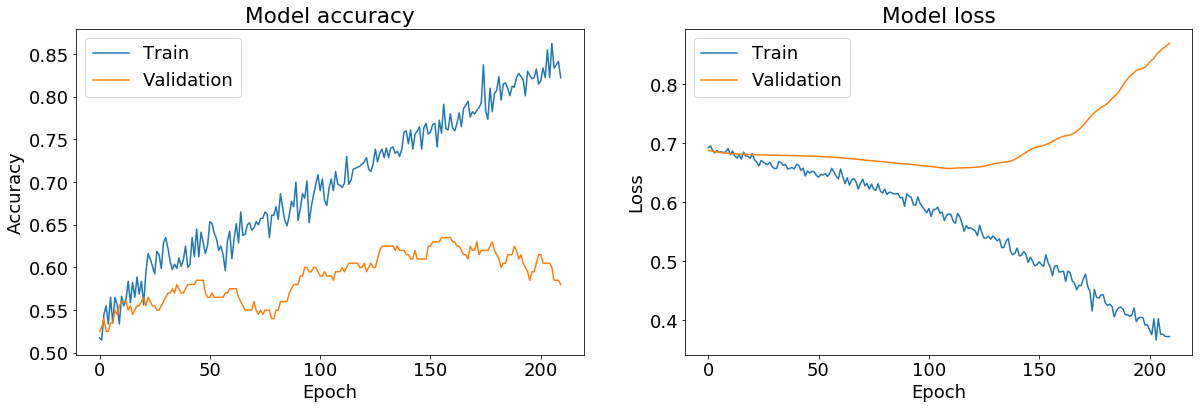

In [211]:
# Plot training & validation accuracy values
plt.figure(figsize=(20,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [212]:
from sklearn.metrics import roc_curve

In [213]:
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [214]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [215]:
print(auc_keras)

0.6574858223062382


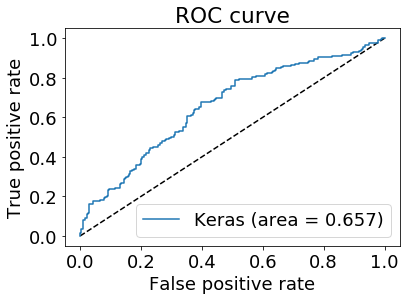

In [216]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [217]:
from sklearn.metrics import classification_report

In [218]:
print(classification_report(y_test, model.predict_classes(X_test), target_names=['Not_Stressed', 'Stressed']))

              precision    recall  f1-score   support

Not_Stressed       0.63      0.62      0.63       230
    Stressed       0.63      0.63      0.63       230

   micro avg       0.63      0.63      0.63       460
   macro avg       0.63      0.63      0.63       460
weighted avg       0.63      0.63      0.63       460



In [219]:
from sklearn.metrics import confusion_matrix

In [220]:
confusion_matrix(y_test, model.predict_classes(X_test))

array([[143,  87],
       [ 84, 146]])

In [85]:
# np.concatenate((np.around(model.predict(X_test), decimals=2), y_test), axis=1)

In [222]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

In [232]:
cnn_model = Sequential()
cnn_model.add(Conv1D(64, 3, activation='relu', input_shape=(sequence_length, 30)))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(MaxPooling1D(3))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(Conv1D(64, 3, activation='relu'))
cnn_model.add(GlobalAveragePooling1D())
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [233]:
cnn_model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=200, validation_split=0.2, shuffle=False, callbacks=my_callbacks)
# model.fit(X_train, y_train, batch_size=16, epochs=50)
cnn_score = cnn_model.evaluate(X_test, y_test)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 2s 2ms/step - loss: 0.7140 - acc: 0.4775 - val_loss: 0.7429 - val_acc: 0.4800
Epoch 2/200
800/800 [==============================] - 0s 21us/step - loss: 0.7347 - acc: 0.5025 - val_loss: 0.6901 - val_acc: 0.5500
Epoch 3/200
800/800 [==============================] - 0s 18us/step - loss: 0.6906 - acc: 0.5225 - val_loss: 0.6896 - val_acc: 0.5550
Epoch 4/200
800/800 [==============================] - 0s 17us/step - loss: 0.6831 - acc: 0.5612 - val_loss: 0.6872 - val_acc: 0.5900
Epoch 5/200
800/800 [==============================] - 0s 16us/step - loss: 0.6805 - acc: 0.5838 - val_loss: 0.6853 - val_acc: 0.5900
Epoch 6/200
800/800 [==============================] - 0s 16us/step - loss: 0.6766 - acc: 0.5813 - val_loss: 0.6835 - val_acc: 0.5800
Epoch 7/200
800/800 [==============================] - 0s 16us/step - loss: 0.6643 - acc: 0.6413 - val_loss: 0.6807 - val_acc: 0.5800
Epoch 8/200
800/8

In [234]:
cnn_score

[0.6735325507495714, 0.6043478260869565]

In [235]:
cnn_score_train = cnn_model.evaluate(X_train, y_train)
cnn_score_train

1000/1000 [==============================] - 0s 93us/step


[0.5654343605041504, 0.725]

In [274]:
print(classification_report(y_test, cnn_model.predict_classes(X_test), target_names=['Not_Stressed', 'Stressed']))

              precision    recall  f1-score   support

Not_Stressed       0.58      0.73      0.65       230
    Stressed       0.64      0.48      0.55       230

   micro avg       0.60      0.60      0.60       460
   macro avg       0.61      0.60      0.60       460
weighted avg       0.61      0.60      0.60       460



In [231]:
cnn_model.save('CNN_Model.h5')

In [91]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [236]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [255]:
clstm_model = Sequential()
clstm_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
clstm_model.add(MaxPooling1D(pool_size=2))
clstm_model.add(LSTM(32, activation='tanh'))
# model.add(Dense(16, activation='tanh'))
clstm_model.add(Dense(1, activation='sigmoid'))

In [256]:
clstm_model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

In [257]:
clstm_model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=200, validation_split=0.2, shuffle=False, callbacks=my_callbacks)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 2s 3ms/step - loss: 0.7311 - acc: 0.4850 - val_loss: 0.7191 - val_acc: 0.5200
Epoch 2/200
800/800 [==============================] - 0s 66us/step - loss: 0.7189 - acc: 0.4888 - val_loss: 0.7087 - val_acc: 0.5150
Epoch 3/200
800/800 [==============================] - 0s 62us/step - loss: 0.7066 - acc: 0.4900 - val_loss: 0.7018 - val_acc: 0.4850
Epoch 4/200
800/800 [==============================] - 0s 66us/step - loss: 0.6978 - acc: 0.5188 - val_loss: 0.6991 - val_acc: 0.4900
Epoch 5/200
800/800 [==============================] - 0s 69us/step - loss: 0.6932 - acc: 0.5312 - val_loss: 0.6985 - val_acc: 0.4850
Epoch 6/200
800/800 [==============================] - 0s 73us/step - loss: 0.6912 - acc: 0.5275 - val_loss: 0.6975 - val_acc: 0.5000
Epoch 7/200
800/800 [==============================] - 0s 78us/step - loss: 0.6893 - acc: 0.5387 - val_loss: 0.6949 - val_acc: 0.5200
Epoch 8/200
800/8

In [258]:
clstm_scores = clstm_model.evaluate(X_test, y_test, verbose=0)

In [259]:
clstm_scores

[0.6683577185091765, 0.6000000005183013]

In [260]:
clstm_score_train = clstm_model.evaluate(X_train, y_train)
clstm_score_train

1000/1000 [==============================] - 0s 347us/step


[0.6463815197944641, 0.645]

In [275]:
print(classification_report(y_test, clstm_model.predict_classes(X_test), target_names=['Not_Stressed', 'Stressed']))

              precision    recall  f1-score   support

Not_Stressed       0.60      0.58      0.59       230
    Stressed       0.60      0.62      0.61       230

   micro avg       0.60      0.60      0.60       460
   macro avg       0.60      0.60      0.60       460
weighted avg       0.60      0.60      0.60       460



In [261]:
clstm_model.save('CNN-LSTM_Model.h5')

In [264]:
y_pred_cnn = cnn_model.predict(X_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

In [265]:
y_pred_clstm = clstm_model.predict(X_test).ravel()
fpr_clstm, tpr_clstm, thresholds_clstm = roc_curve(y_test, y_pred_clstm)
auc_clstm = auc(fpr_clstm, tpr_clstm)

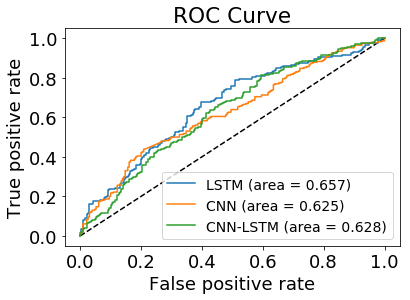

In [273]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='LSTM (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_cnn, tpr_cnn, label='CNN (area = {:.3f})'.format(auc_cnn))
plt.plot(fpr_clstm, tpr_clstm, label='CNN-LSTM (area = {:.3f})'.format(auc_clstm))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc=4, prop={'size': 14})
plt.show()